In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tensorflow as tf

import sys
sys.path.append('/mnt/c/Users/kheut/code/covid19-forecasting/tf_model_1p5/')

from enum import Enum

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense

import tensorflow_probability as tfp
from scipy.stats import beta, truncnorm


# Local imports from model.py, data.py
from model import CovidModel, LogPoissonProb, get_logging_callbacks, Comp, Vax
from data import read_data, create_warmup
#from plots import make_all_plots

import scipy

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20}) # set plot font sizes

2021-11-28 16:41:52.332060: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-28 16:41:52.332091: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
transition_window =3

warmup_start = '20210428'
warmup_end = '20210430'
train_start = '20210501'
train_end = '20210731'
test_start = '20210801'
test_end = '20210831'

state = 'Massachusetts'
state_abbrev = 'MA'

data_dir = '../data'
covid_estim_date = '20210901'
hhs_date = '20210903'
owid_date = '20210903'

log_dir = './logs/new_warmup'


# Learning rate
learning_rate = 1e-4

In [3]:
df = read_data(data_dir=data_dir,
               covid_estim_date=covid_estim_date,
               hhs_date=hhs_date,
               owid_date=owid_date,
               state=state, state_abbrev=state_abbrev)

In [4]:
class Comp(Enum):
    A = 0
    M = 1
    #X = 2
    #G = 3
    
class Vax(Enum):
    total = -1
    no = 0
    yes = 1

In [5]:
# get warmup arrays, splitting on vaccination status
warmup_asymp, warmup_mild, warmup_extreme = create_warmup(df, 
                                                          warmup_start, 
                                                          warmup_end,
                                                          0,0,0)

# re-combine
warmup_asymp = warmup_asymp[Vax.no.value] + warmup_asymp[Vax.yes.value]

In [6]:
synth_T_serial = 5.8
synth_rho_M = 0.76
synth_lambda_M = 4.7
synth_nu_M = 3.1

In [7]:
warmup_A_params = {}
warmup_A_params[Vax.total.value] = {}
warmup_A_params[Vax.total.value]['prior'] = []
warmup_A_params[Vax.total.value]['posterior_init'] = []

for day in range(transition_window):
    warmup_A_params[Vax.total.value]['prior'].append({'loc': warmup_asymp[day],
                                                'scale': warmup_asymp[day]/10})
    

In [8]:
x_train = tf.cast(df.loc[train_start:test_end,'Rt'].values, dtype=tf.float32)
y_test = tf.cast(df.loc[train_start:test_end,'mild'], dtype=tf.float32)

2021-11-28 16:41:59.651933: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-28 16:41:59.652099: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-28 16:41:59.652130: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-11-28 16:41:59.652153: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-11-28 16:41:59.652175: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [9]:
A_vals = []
M_vals =[]
for day in range(transition_window):
    A_vals.append(warmup_A_params[-1]['prior'][day]['loc'])

for day in range(len(x_train)):
    yesterday_asymp = A_vals[-1]
    
    today_asymp = yesterday_asymp*x_train[day]**(1/synth_T_serial)
    A_vals.append(today_asymp)
    
    today_M = 0
    pi_M=[]
    for j in range(transition_window):
        
        
        lambda_M_fix = synth_lambda_M
        nu_M_fix = synth_nu_M
        poisson_dist = scipy.stats.poisson(lambda_M_fix)
        pi_M_j_ago = poisson_dist.logpmf(j+1)/nu_M_fix
        
        pi_M.append(pi_M_j_ago)
    
    pi_M = scipy.special.softmax(pi_M)
        
    for j in range(transition_window):
        j_ago_asymp = A_vals[day-j-1]
        today_M += j_ago_asymp*synth_rho_M*pi_M[j]
        
    M_vals.append(today_M)

In [10]:

T_serial = {}
T_serial[Vax.total.value] = {}
T_serial[Vax.total.value]['prior'] ={'loc':5.8, 'scale':1}


rho_M = {}
rho_M[Vax.total.value] = {}
rho_M[Vax.total.value]['prior'] = {'a': 31.8, 'b': 10.3}

lambda_M = {}
lambda_M[Vax.total.value] = {}
lambda_M[Vax.total.value]['prior'] = {'loc': 4.7, 'scale': 1}

nu_M = {}
nu_M[Vax.total.value] = {}
nu_M[Vax.total.value]['prior'] = {'loc': 3.1, 'scale': 1.2}




In [11]:
variance_scales = np.logspace(-2,2,20)

In [12]:
T_serial_scale = 1.0
rho_M_scale = 0.1
lambda_M_scale = 1.0
nu_M_scale = 1.2

warmup_scales = [0.1, 0.1, 0.1]

In [13]:
 
T_serial[Vax.total.value]['posterior_init'] = {'loc': tfp.math.softplus_inverse(synth_T_serial),
                                     'scale':tf.cast(tfp.math.softplus_inverse(T_serial_scale),dtype=tf.float32)}

rho_M[Vax.total.value]['posterior_init'] = {'loc': tf.cast(np.log(synth_rho_M/(1-synth_rho_M)),dtype=tf.float32),
                                      'scale':tf.cast(tfp.math.softplus_inverse(rho_M_scale),dtype=tf.float32)}

lambda_M[Vax.total.value]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(synth_lambda_M),dtype=tf.float32),
                                         'scale':tf.cast(tfp.math.softplus_inverse(lambda_M_scale),dtype=tf.float32)}

nu_M[Vax.total.value]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(synth_nu_M),dtype=tf.float32),
                                     'scale':tf.cast(tfp.math.softplus_inverse(nu_M_scale),dtype=tf.float32)}

for day in range(transition_window):
    # must be positive so reverse softplus the mean
    warmup_A_params[Vax.total.value]['posterior_init'].append({'loc': tf.cast(tfp.math.softplus_inverse(warmup_asymp[day]),dtype=tf.float32),
                                                         'scale': tf.cast(tfp.math.softplus_inverse(warmup_scales[day]),dtype=tf.float32)})#tf.cast(tfp.math.softplus_inverse(warmup_asymp[day]/10),dtype=tf.float32)})

model = CovidModel([Vax.total], [Comp.A, Comp.M],
                 transition_window,
                T_serial, rho_M, lambda_M, nu_M,
                 warmup_A_params, posterior_samples=1000)

loss = LogPoissonProb() 
optimizer = tf.keras.optimizers.SGD(
    learning_rate=learning_rate, #momentum=0.98, nesterov=False, name='SGD'
)

with tf.GradientTape() as tape:
    model._constrain_parameters()
    model._sample_and_reparameterize()
    model._add_prior_loss()
    loss_val = sum(model.losses)

2021-11-28 16:42:56.749964: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [14]:
model.prior_distros[Comp.A.value][Vax.total.value]['T_serial'].log_prob(model.T_serial_samples_constrained) * \
            tfp.bijectors.Softplus().forward_log_det_jacobian(model.T_serial_samples)

<tf.Tensor: shape=(1000,), dtype=float32, numpy=
array([0.01952894, 0.00145729, 0.0018744 , 0.00131934, 0.00428906,
       0.00147112, 0.00433148, 0.01709144, 0.00182037, 0.00167252,
       0.00220884, 0.00229325, 0.00350728, 0.00148619, 0.00265752,
       0.00443692, 0.00196534, 0.01311308, 0.05423368, 0.00308103,
       0.00116908, 0.00170279, 0.00429723, 0.01038291, 0.00643191,
       0.00385537, 0.00206879, 0.00144968, 0.03456198, 0.06925512,
       0.0253077 , 0.0035436 , 0.00217361, 0.00161645, 0.00303355,
       0.00187355, 0.00252607, 0.00137878, 0.00154347, 0.0035559 ,
       0.00738007, 0.00140918, 0.00888843, 0.00301029, 0.00419536,
       0.00969133, 0.0014859 , 0.00366211, 0.00110381, 0.00156658,
       0.0041184 , 0.0014154 , 0.03857578, 0.0017721 , 0.00326101,
       0.00585897, 0.02493339, 0.00271512, 0.00215861, 0.0040522 ,
       0.00509723, 0.00271698, 0.00172391, 0.00247081, 0.00174468,
       0.00669833, 0.06304649, 0.00172182, 0.00148789, 0.00206581,
       0.0032

In [15]:
alternative_T_serial_prior = scipy.stats.norm(5.8,1)

In [16]:
u_Tserial_range = np.linspace(1e-8,10,1000)

In [17]:
prior_probabilities_from_model = model.prior_distros[Comp.A.value][Vax.total.value]['T_serial'].log_prob(u_Tserial_range) + \
            tfp.bijectors.Softplus().forward_log_det_jacobian(
            tf.cast(tfp.bijectors.Softplus().inverse(u_Tserial_range),
                    dtype=tf.float32)
)

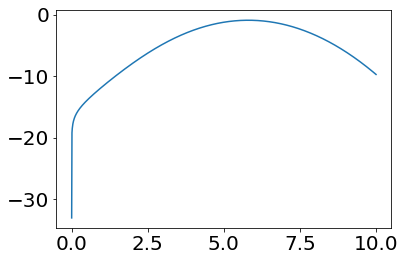

In [18]:
plt.plot(u_Tserial_range, prior_probabilities_from_model)

In [19]:
alternative_log_probs = alternative_T_serial_prior.logpdf(u_Tserial_range)
unconstrained_thetas = np.log(np.exp(u_Tserial_range) - 1.)
jacobian_adjustment = np.exp(unconstrained_thetas)/(1+np.exp(unconstrained_thetas))
prior_probabilities_hand_calc = alternative_log_probs +  np.log(jacobian_adjustment)

Text(0.5, 1.0, 'Prior Probability vs T_serial')

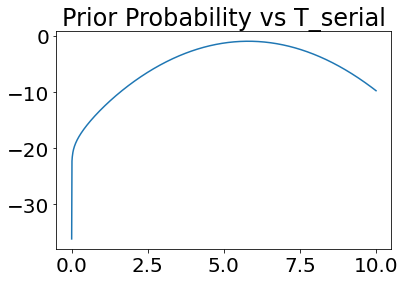

In [20]:
plt.plot(u_Tserial_range, prior_probabilities_hand_calc)
plt.title('Prior Probability vs T_serial')

Text(0.5, 1.0, 'Transformed Prior Likelihood vs T_serial')

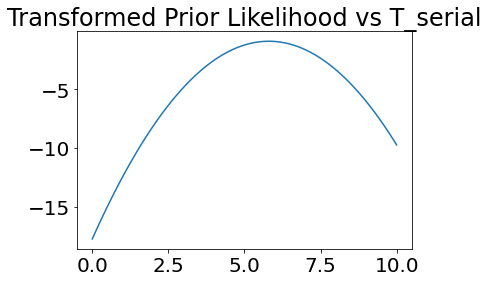

In [21]:
plt.plot(u_Tserial_range,alternative_log_probs)
plt.title('Transformed Prior Likelihood vs T_serial')

In [22]:
T_serial_variational_posterior = tfp.distributions.Normal(model.T_serial_params[Vax.total.value]['loc'],
                                                                  model.T_serial_params[Vax.total.value]['scale'])

In [23]:
T_serial_probs = T_serial_variational_posterior.log_prob(u_Tserial_range)

Text(0.5, 1.0, 'Transformed Posterior Likelihood vs T_serial')

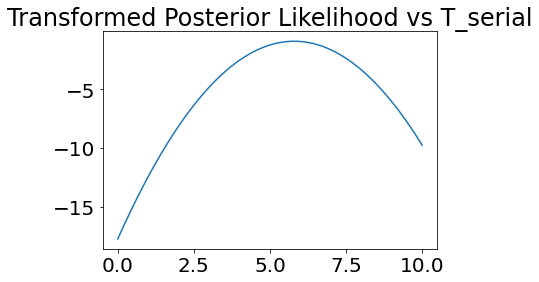

In [24]:
plt.plot(u_Tserial_range,T_serial_probs)
plt.title('Transformed Posterior Likelihood vs T_serial')

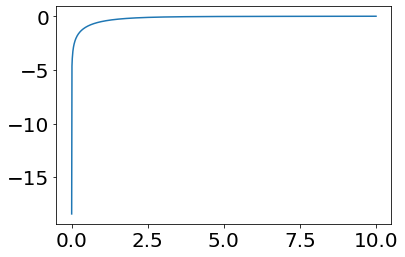

In [25]:
plt.plot(u_Tserial_range,prior_probabilities_hand_calc-T_serial_probs)

In [26]:
max(prior_probabilities_hand_calc-T_serial_probs)

<tf.Tensor: shape=(), dtype=float32, numpy=0.012693405>

In [30]:
prior_probabilities_hand_calc-T_serial_probs

<tf.Tensor: shape=(1000,), dtype=float32, numpy=
array([-1.84382610e+01, -4.62672234e+00, -3.93853760e+00, -3.53802681e+00,
       -3.25528908e+00, -3.03708458e+00, -2.85968971e+00, -2.71046066e+00,
       -2.58184052e+00, -2.46896172e+00, -2.36849594e+00, -2.27807236e+00,
       -2.19594002e+00, -2.12076759e+00, -2.05152130e+00, -1.98738289e+00,
       -1.92768669e+00, -1.87190056e+00, -1.81957054e+00, -1.77032471e+00,
       -1.72384262e+00, -1.67985725e+00, -1.63813019e+00, -1.59846687e+00,
       -1.56068611e+00, -1.52463341e+00, -1.49017334e+00, -1.45718765e+00,
       -1.42556572e+00, -1.39521217e+00, -1.36603737e+00, -1.33796787e+00,
       -1.31093121e+00, -1.28486443e+00, -1.25970554e+00, -1.23540688e+00,
       -1.21191597e+00, -1.18918610e+00, -1.16717815e+00, -1.14585876e+00,
       -1.12518883e+00, -1.10513020e+00, -1.08566380e+00, -1.06675243e+00,
       -1.04837799e+00, -1.03050709e+00, -1.01312542e+00, -9.96206284e-01,
       -9.79733467e-01, -9.63683128e-01, -9.4804477